# [프로젝트] 청와대 청원으로 하는 한글 자연어 처리

- 일자: 2020-07-12
- 작성자: 박하람 
- 참고자료: 파이썬으로 데이터 주무르기(민형기) 

교재에는 한낮 애인 선물 구하기라는 주제라(ㅋㅋ) 유치하니 청와대 청원을 분석해보겠습니다. 제가 팀프로젝트로 했던 주제인데, 같이 해보면 재미있을 것 같아 청와대 청원 데이터를 가져와봤습니다. 데이터 범위는 '답변된 청원'으로만 한정할 것이고요, 현재(2020.07.11)은 176호까지 답변된 청원이 있습니다. 

먼저 [청와대 청원 홈페이지](https://www1.president.go.kr/petitions/answer)에서 모든 청원들을 가져와 데이터 프레임에 담고, 여러 카테고리 중 청원수가 많은 상위 1개의 카테고리를 선택해 청원 내용을 wordcloud로 시각화해보겠습니다. 또한 gensim을 활용해 Word2Vec으로 유사한 단어들도 함께 파악해보겠습니다! 

## 답변된 청원 웹크롤링 하기 

우선 먼저 구상해보시기를 제안드릴게요. 어떻게 하면 '답변된 청원'을 모두 가져올 수 있을까요? 여러 페이지에 걸쳐 있는 청원들을 어떻게 웹크롤링으로 가져올 수 있을까요? 이러한 사고 없이 코드만 먼저 보시게 되면 실질적인 문제 해결 역량은 성장하지 못할 수도...🌝 그러니 한번 어떻게 크롤링해올 것인가 고민해보시고, 이제까지 배운 크롤링들을 모두 활용하여 크롤링해봐야지! 라는 생각으로 최대한 고민하고 해보고 잘 안풀릴 때 코드를 보시면 더욱 더욱 큰 도움이 될 수 있을 것 같습니다. 참고로 아래 크롤링 코드는 모두 제가 짠 것이라 비효율적이고 지저분할 수 있지만, 어쨌든 잘 가져와서 데이터 프레임에 담았습니다ㅎㅎ 

**힌트:**
- urllib과 BeautifulSoup을 활용해 웹크롤링 
- 여러 페이지의 웹크롤링은 지난 스터디 '샌드위치 맛집 크롤링'을 활용

빈공간에 한번 생각해보시고 아래 코드를 보시면 더욱 도움이 됩니다! 따로 부연설명은 많이 적지 않았구요, 혼자 먼저 해보시고 잘 안되는 부분에서 고민을 하고 이 코드를 보시면 해결이 될 수 있을 것 같네요~🙃

In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd

In [ ]:
titles = []
start_date = []
end_date = []
num_consent = []
answer_date = []
address = []

def get_info(url): 
    res = urlopen(url)
    soup = BeautifulSoup(res, "html.parser")
    
    # get titles, address(url)
    contents = soup.find_all('div', class_='ans_name_title')
    for n in range(0,len(contents)):
        content = contents[n]
        titles.append(content.a.get_text())
        add_url = str(content.find('a')['href'])
        address.append('https://www1.president.go.kr'+add_url)
    
    # 청원시작과 끝 날짜, 참여인원, 답변일 정보 얻기 
    infos = soup.find_all('ol', class_='ans_name_info')
    for info in infos: 
        start_date.append(info.find('p', class_='ans_list1_2').get_text()[2:-2])
        end_date.append(info.find('p', class_='ans_list2_2').get_text()[2:-2])
        num_consent.append(info.find('p', class_='ans_list3_2').get_text()[2:-2])
        answer_date.append(info.find('p', class_='ans_list4_2').get_text()[2:-2])          

In [ ]:
# 왜 12페이지까지일까요? 
for n in range(1,13): 
    url = 'https://www1.president.go.kr/petitions/answer?page=%d' % n
    get_info(url)

In [ ]:
data = {'제목':titles, '청원시작일':start_date, '청원종료일': end_date,
       '참여인원': num_consent, '청원답변일':answer_date, 'URL':address}
df = pd.DataFrame(data)
df.head()

,제목,청원시작일,청원종료일,참여인원,청원답변일,URL
0,저희 아파트 경비아저씨의 억울함을 풀어주세요...,2020. 05. 11,2020. 06. 10,"446,434",2020. 07. 08,https://www1.president.go.kr/petitions/588752
1,"울산 초등학교 1학년 아이에게 팬티빨기 숙제내고 학생 사진에 '섹시팬티', '공주님...",2020. 04. 28,2020. 05. 28,"225,764",2020. 06. 26,https://www1.president.go.kr/petitions/588455
2,등교 개학 시기를 미루어주시기 바랍니다.,2020. 04. 24,2020. 05. 24,"255,333",2020. 06. 24,https://www1.president.go.kr/petitions/588340
3,방송통신위원회는 방송의 공적 책임 방기하고 언론이기를 포기한 채널A와 TV조선의 ...,2020. 04. 07,2020. 05. 07,"273,513",2020. 06. 05,https://www1.president.go.kr/petitions/587827
4,렌트카 훔쳐 사망사고를 낸 10대 엄중 처벌해주세요,2020. 04. 02,2020. 05. 02,"1,007,040",2020. 06. 02,https://www1.president.go.kr/petitions/587624


In [ ]:
# 1차 저장 
df.to_csv('BlueHouse Petition data.csv', sep=',', encoding='utf-8')

여기까지 1차 저장을 해주었습니다. 각 청원 페이지에 들어가 세부 내용과 함께 청원 답변 등까지 모두 가져와 볼거에요.

In [ ]:
import pandas as pd

# thousands는 왜 할까요? 
petition = pd.read_csv('BlueHouse Petition data.csv', thousands=',', encoding='utf-8', index_col=0)
petition.head()

,제목,청원시작일,청원종료일,참여인원,청원답변일,URL
0,저희 아파트 경비아저씨의 억울함을 풀어주세요...,2020. 05. 11,2020. 06. 10,446434,2020. 07. 08,https://www1.president.go.kr/petitions/588752
1,"울산 초등학교 1학년 아이에게 팬티빨기 숙제내고 학생 사진에 '섹시팬티', '공주님...",2020. 04. 28,2020. 05. 28,225764,2020. 06. 26,https://www1.president.go.kr/petitions/588455
2,등교 개학 시기를 미루어주시기 바랍니다.,2020. 04. 24,2020. 05. 24,255333,2020. 06. 24,https://www1.president.go.kr/petitions/588340
3,방송통신위원회는 방송의 공적 책임 방기하고 언론이기를 포기한 채널A와 TV조선의 ...,2020. 04. 07,2020. 05. 07,273513,2020. 06. 05,https://www1.president.go.kr/petitions/587827
4,렌트카 훔쳐 사망사고를 낸 10대 엄중 처벌해주세요,2020. 04. 02,2020. 05. 02,1007040,2020. 06. 02,https://www1.president.go.kr/petitions/587624


In [ ]:
len(petition)

177

의도한 청원 개수만큼 가져와졌습니다! 아래 코드는 대략 5-7분 정도 소요됩니다. 중간에 time.sleep()을 넣을 까닭은 청와대 청원에서 웹크롤링(?) 매크로(?)를 막는 게 있는 것 같은데 시간을 주어서 헷갈리게(?) 하면 크롤링 됩니다(ㅋㅋㅋ)

In [ ]:
import re 
import time
from tqdm import tqdm_notebook
from urllib.request import urlopen
from bs4 import BeautifulSoup

category =[]
content = []
answer = []
person = []

for n in tqdm_notebook(petition.index): 
    url = urlopen(petition['URL'][n]) 
    if n / 2 == 0:
        time.sleep(1)
    else: 
        time.sleep(2)
    soup = BeautifulSoup(url, "html.parser") 
    
    # get category 
    sector = soup.find('ul', class_='petitionsView_info_list')
    try: 
        category.append(sector.li.get_text()[4:])
    except AttributeError:
        print('AttributeError: index-', n, 'URL-', petition['URL'][n])
    person.append(sector.find_all('li')[3].get_text()[3:-6])


    # get petition content 
    content_raw = soup.find_all('div', class_='View_write')
    try: 
        if len(content_raw) > 1:
            content_raw_text = content_raw[1].get_text()
        else: 
            content_raw_text = content_raw[0].get_text()   
    except IndexError: 
        print('IndexError:', petition['URL'][n])
    
    content_split = re.split('\r|\t|\n|\xa0', content_raw_text)
    content.append(''.join(content_split))

    # get petition answer 
    answer_raw = soup.find_all('div', class_='pr_tk25')
    if len(answer_raw) > 1: 
        answer_raw_text = re.split("\r|\t|\n|\xa0", answer_raw[1].get_text())
    else: 
        answer_raw_text = re.split("\r|\t|\n|\xa0", answer_raw[0].get_text())
    answer_raw_text = ' '.join(answer_raw_text)
    answer.append(answer_raw_text[7:]) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [ ]:
print(len(category), len(content), len(answer), len(person))

177 177 177 177


잘 출력되었습니다!

In [ ]:
petition['카테고리'] = category
petition['청원내용'] = content
petition['청원답변'] = answer
petition['청원인'] = person

제대로 크롤링 되지 않는 부분은 없는지 확인해봅니다. 크롤링한 데이터를 저장해 파일로 열어본 후 전체를 쭉 확인해보는 것도 중요한 작업이라 생각합니다 :-) 

In [ ]:
petition[petition['청원내용'] == '']

,제목,청원시작일,청원종료일,참여인원,청원답변일,URL,카테고리,청원내용,청원답변,청원인
147,합정 **** 불법 누드촬영,2018. 05. 17,2018. 06. 16,201590,2018. 05. 21,https://www1.president.go.kr/petitions/235102,인권/성평등,,,naver
148,위장•몰래카메라 판매금지와 몰카범죄 처벌을 강화해주세요.,2018. 03. 23,2018. 04. 22,209494,2018. 05. 21,https://www1.president.go.kr/petitions/173355,안전/환경,,,naver
149,여성도 대한민국 국민입니다. 성별 관계없는 국가의 보호를 요청합니다.,2018. 05. 11,2018. 06. 10,419006,2018. 05. 21,https://www1.president.go.kr/petitions/230552,인권/성평등,,,naver
152,다산신도시 실버택배 비용은 입주민들의 관리비로 충당해야합니다.,2018. 04. 17,2018. 05. 17,302082,2018. 05. 04,https://www1.president.go.kr/petitions/203181,행정,,,naver


In [ ]:
for n in [147, 148, 149, 152]:
    url = urlopen(petition['URL'][n]) 
    soup = BeautifulSoup(url, "html.parser") 
    
    # get petition content 
    content_raw = soup.find_all('div', class_='View_write')
    content_raw_text = content_raw[2].get_text()
    content_split = re.split('\r|\t|\n|\xa0', content_raw_text)
    petition['청원내용'][n] = ''.join(content_split)
    
    # get petition answer 
    answer_raw = soup.find_all('div', class_='pr_tk25')
    answer_raw_text = re.split("\r|\t|\n|\xa0", answer_raw[2].get_text())
    answer_raw_text = ' '.join(answer_raw_text)
    petition['청원답변'][n] = answer_raw_text[7:]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [ ]:
petition.to_csv('Final BlueHouse Petition data.csv', sep=',', encoding='utf-8')

여기까지가 데이터를 가져오는 과정이었습니다. 이 파일들은 다운로드를 해두신다음에 다음에 실행하실 때에는 파일을 드래그 하여 넣으신 다음에 쓰세요. 계속 크롤링하신 다음 이후 코드를 실행하시려고 하면 시간이 항상 오래 소요되실 겁니다..ㅎㅎ

## EDA(Exploratory Data Analysis) 
### 탐색적 자료 분석 



In [4]:
import pandas as pd
import platform
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 81 not upgraded.


In [6]:
petition = pd.read_csv('Final BlueHouse Petition data.csv', 
                       index_col=0, parse_dates=['청원시작일','청원종료일','청원답변일'])
petition.head()

,제목,청원시작일,청원종료일,참여인원,청원답변일,URL,카테고리,청원내용,청원답변,청원인
0,저희 아파트 경비아저씨의 억울함을 풀어주세요...,2020-05-11,2020-06-10,446434,2020-07-08,https://www1.president.go.kr/petitions/588752,인권/성평등,안녕하세요 저는 **동 **아파트 2동에 거주한지 이제 2년째 되가는 입주민입니다....,안녕하십니까. 국토교통비서관 윤성원입니다. 안녕하십니까 고용노동비서관 조성재입니...,kakao
1,"울산 초등학교 1학년 아이에게 팬티빨기 숙제내고 학생 사진에 '섹시팬티', '공주님...",2020-04-28,2020-05-28,225764,2020-06-26,https://www1.president.go.kr/petitions/588455,육아/교육,안녕하십니까?저는 아이들의 인권이 최우선이라고 생각하며두 남매를 열심히 키우고 있는...,안녕하십니까. 청와대 교육비서관 박경미입니다. 울산의 한 초등학교 교사의 성비위...,naver
2,등교 개학 시기를 미루어주시기 바랍니다.,2020-04-24,2020-05-24,255333,2020-06-24,https://www1.president.go.kr/petitions/588340,육아/교육,"최근 코로나19의 신규 확진자 수가 50명 이하로 감소하였고, 정부는 등교 개학을 ...",안녕하십니까. 부총리 겸 교육부 장관 유은혜입니다. 코로나19가 완전히 종식되거...,kakao
3,방송통신위원회는 방송의 공적 책임 방기하고 언론이기를 포기한 채널A와 TV조선의 ...,2020-04-07,2020-05-07,273513,2020-06-05,https://www1.president.go.kr/petitions/587827,문화/예술/체육/언론,최근 MBC의 잇따른 보도에 따르면 종편 채널A 기자가 현직 검사장과의 친분을 내세...,안녕하십니까. 방송통신위원회 위원장 한상혁입니다. 오늘 답변드릴 ‘채널A와 TV조선...,facebook
4,렌트카 훔쳐 사망사고를 낸 10대 엄중 처벌해주세요,2020-04-02,2020-05-02,1007040,2020-06-02,https://www1.president.go.kr/petitions/587624,기타,29일 오전 0시 1분쯤 대전 동구의 한 네거리에서 훔친 렌터카를 몰던 10대 청소...,안녕하십니까. 디지털소통센터장 강정수입니다. 오늘은 「렌트카 훔쳐 사망사고 낸 ...,facebook


In [7]:
petition.shape

(177, 10)

### 필요한 데이터만 남기기

분석에 필요한 데이터들만 남겨봅니다.

In [8]:
petition.drop(['URL', '청원종료일','청원답변','청원인'], axis=1, inplace=True)
petition.head()

,제목,청원시작일,참여인원,청원답변일,카테고리,청원내용
0,저희 아파트 경비아저씨의 억울함을 풀어주세요...,2020-05-11,446434,2020-07-08,인권/성평등,안녕하세요 저는 **동 **아파트 2동에 거주한지 이제 2년째 되가는 입주민입니다....
1,"울산 초등학교 1학년 아이에게 팬티빨기 숙제내고 학생 사진에 '섹시팬티', '공주님...",2020-04-28,225764,2020-06-26,육아/교육,안녕하십니까?저는 아이들의 인권이 최우선이라고 생각하며두 남매를 열심히 키우고 있는...
2,등교 개학 시기를 미루어주시기 바랍니다.,2020-04-24,255333,2020-06-24,육아/교육,"최근 코로나19의 신규 확진자 수가 50명 이하로 감소하였고, 정부는 등교 개학을 ..."
3,방송통신위원회는 방송의 공적 책임 방기하고 언론이기를 포기한 채널A와 TV조선의 ...,2020-04-07,273513,2020-06-05,문화/예술/체육/언론,최근 MBC의 잇따른 보도에 따르면 종편 채널A 기자가 현직 검사장과의 친분을 내세...
4,렌트카 훔쳐 사망사고를 낸 10대 엄중 처벌해주세요,2020-04-02,1007040,2020-06-02,기타,29일 오전 0시 1분쯤 대전 동구의 한 네거리에서 훔친 렌터카를 몰던 10대 청소...


### 카테고리별 청원수 


In [9]:
petition_cate = petition['카테고리'].value_counts()
petition_cate

인권/성평등         47
정치개혁           24
기타             23
안전/환경          22
문화/예술/체육/언론    15
육아/교육          12
반려동물            8
보건복지            6
교통/건축/국토        5
외교/통일/국방        5
행정              3
성장동력            2
미래              2
경제민주화           2
일자리             1
Name: 카테고리, dtype: int64

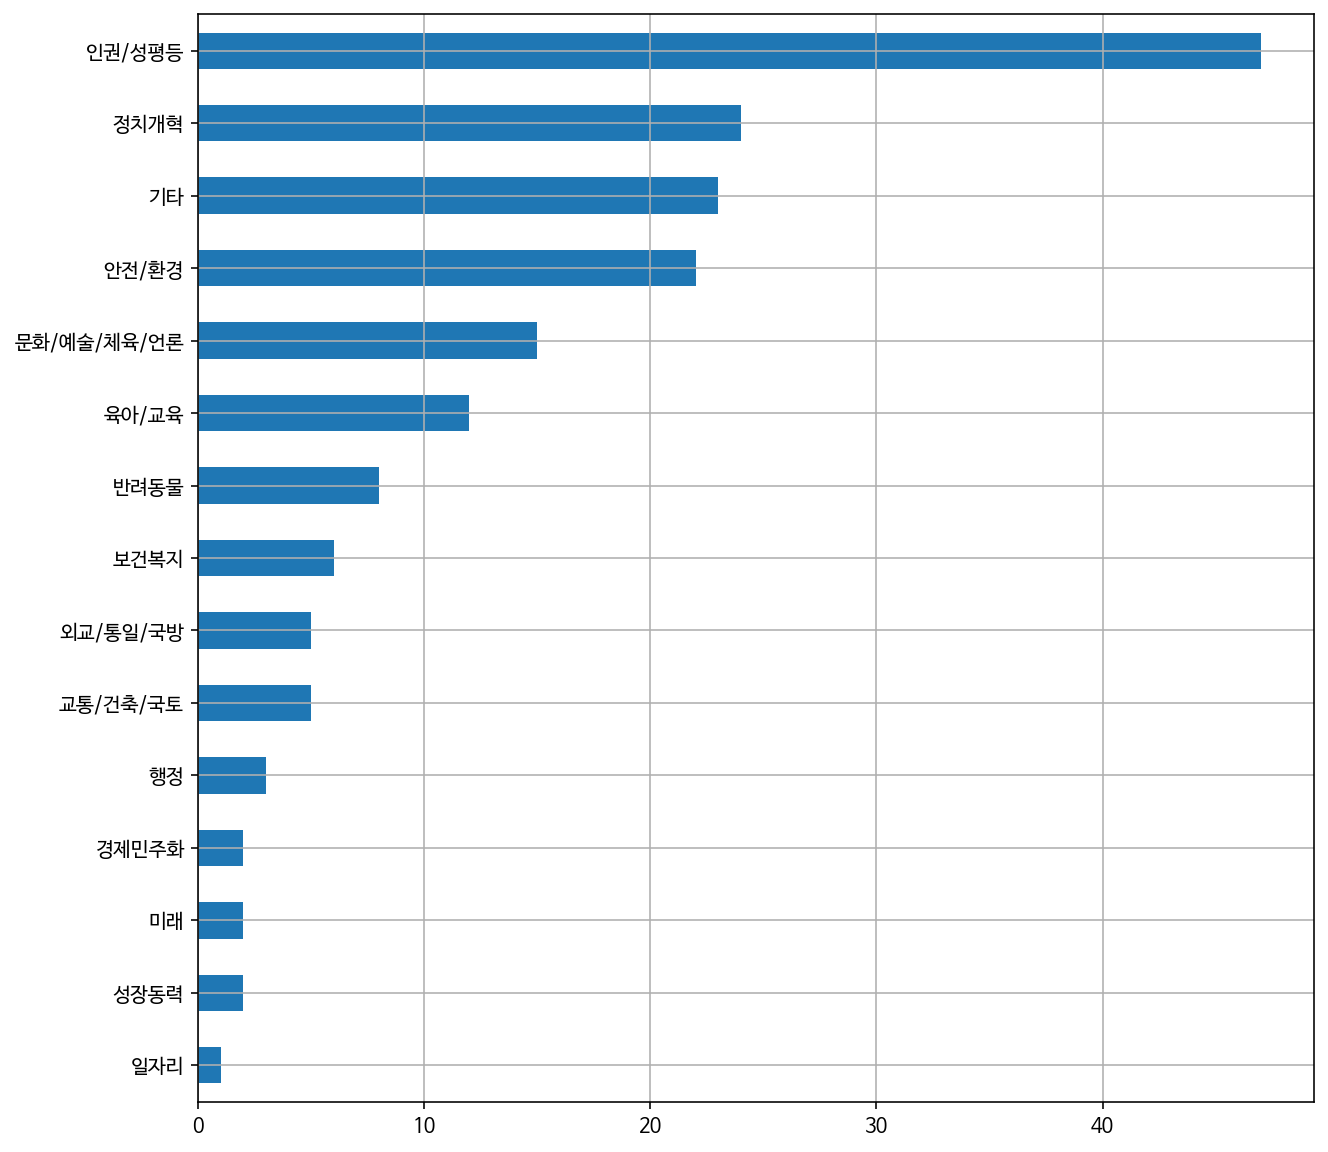

In [10]:
petition_cate.sort_values().plot(kind='barh', grid=True, figsize=(10,10))
plt.show()

청원수가 많은 영역은 인권/성평등, 정치개혁, 기타 순으로 청원이 많다는 것을 알 수 있습니다. 

### WordCloud로 시각화

인권/성평등 분야의 청원내용을 wordcloud로 시각화해봅시다! 인권/성평등 분야만 새로운 변수에 담아주었고 제대로 가져왔는지까지 확인해주는 것 잊지 마세요.

In [11]:
humanRights = petition[petition['카테고리'] == '인권/성평등']
humanRights.shape

(47, 6)

In [12]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk python-dev python3-dev 
!pip3 install JPype1-py3 
!pip3 install konlpy 
!JAVA_HOME="C:\Program Files\Java\jdk-13.0.2"

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python

In [13]:
import nltk 
from konlpy.tag import Okt 
okt = Okt()

모든 청원내용을 하나의 변수 humanRights_text에다가 모두 넣어두었습니다.

In [14]:
humanRights_text = ''

for each_line in humanRights['청원내용']: 
  humanRights_text = humanRights_text + each_line + '\n'

In [15]:
tokens_ko = okt.morphs(humanRights_text)
tokens_ko

['안녕하세요',
 '저',
 '는',
 '**',
 '동',
 '**',
 '아파트',
 '2',
 '동',
 '에',
 '거주',
 '한지',
 '이제',
 '2년',
 '째',
 '되가는',
 '입',
 '주민',
 '입니다',
 '.',
 '주택',
 '에서만',
 '쭉',
 '살다가',
 '물',
 '좋고',
 '공기',
 '좋은',
 '이',
 '곳',
 '에',
 '와서',
 '행복한',
 '나날',
 '을',
 '보내던',
 '중',
 '어제',
 '정말',
 '허망',
 '하고',
 '억울한',
 '소식',
 '을',
 '들었습니다',
 '.',
 '저희',
 '아파트',
 '경비',
 '아저씨',
 '가',
 '주차',
 '문제',
 '로',
 '인해',
 '4월',
 '말부터',
 '20일',
 '정도',
 '말로',
 '설명',
 '할',
 '수',
 '없이',
 '힘든',
 '폭언',
 '으로',
 '인해',
 '생',
 '을',
 '마감',
 '하셨다는',
 '소식',
 '이',
 '였습니다',
 '...',
 '정말',
 '좋으신',
 '분이셨습니다',
 '.',
 '처음',
 '이사',
 '와',
 '서',
 '저',
 '한테',
 '아니',
 '입',
 '주민',
 '들',
 '에게',
 '매번',
 '잘',
 '해주시고',
 '자기',
 '가족',
 '인',
 '것',
 '처럼',
 '자기',
 '일인',
 '것',
 '처럼',
 '매번',
 '아파트',
 '주민',
 '분들',
 '을',
 '위해',
 '희생',
 '하시는',
 '성실한',
 '분이셨습니다',
 '..',
 '같이',
 '깨끗하게',
 '살아야한',
 '다',
 '면서',
 '아파트',
 '안쪽',
 '청소',
 '도',
 '모자라',
 '아파트',
 '밖',
 '까지',
 '청소',
 '하시는',
 '정말',
 '열심히',
 '사시',
 '는',
 '분이셨습니다',
 '..',
 '아침',
 '마다',
 '먼저',
 '오셔서',
 '안녕하세',
 '유라',


In [16]:
ko = nltk.Text(tokens_ko, name='인권/성평등 청원내용')
print(len(ko.tokens))
print(len(set(ko.tokens))) # 중복 제거 후! 

30941
6161


In [17]:
ko = nltk.Text(tokens_ko, name='여자친구 선물')
ko.vocab().most_common(100)

[('.', 1129),
 ('을', 950),
 ('이', 744),
 ('의', 615),
 ('를', 511),
 ('에', 495),
 (',', 452),
 ('가', 406),
 ('들', 379),
 ('은', 342),
 ('는', 286),
 ('으로', 243),
 ('한', 232),
 ('피해자', 210),
 ('도', 180),
 ('가해자', 176),
 ('수', 167),
 ('에서', 166),
 ('로', 165),
 ('것', 165),
 ('그', 160),
 ('과', 151),
 ('제', 145),
 ('입니다', 144),
 ('할', 140),
 ('하고', 139),
 ('적', 139),
 ("'", 135),
 ('하는', 131),
 ('합니다', 130),
 ('와', 124),
 ('여성', 122),
 ('사건', 114),
 ('에게', 102),
 ('고', 102),
 ('인', 101),
 ('사람', 99),
 ('처벌', 88),
 (')', 85),
 ('생각', 79),
 ('?', 79),
 ('하여', 75),
 ('등', 75),
 ('저', 74),
 ('있습니다', 73),
 ('말', 69),
 ('국민', 67),
 ('까지', 65),
 ('(', 63),
 ('1', 62),
 ('그리고', 61),
 ('다', 60),
 ('2', 59),
 ('만', 58),
 ('딸', 57),
 ('했습니다', 56),
 ('안', 55),
 ('된', 55),
 ('보호', 53),
 ('못', 53),
 ('일', 52),
 ('성', 52),
 ('더', 52),
 ('사진', 52),
 ('범죄', 49),
 ('위', 49),
 ('있는', 48),
 ('성범죄', 48),
 ('해', 47),
 ('\n', 47),
 ('경찰', 47),
 ('청소년', 46),
 ('또한', 46),
 ('명', 45),
 ('하지', 45),
 ('..', 44),
 ('수사', 4

In [18]:
stop_words = ['.','을','이','의','를','에',',','가','들','은','는','으로','한','도',
              '수','에서','로','것','그','과','제','입니다','할','하고','적',"'",'하는',
              '합니다','와','에게','고','인',')','?','하여','등','저','있습니다','말','까지',
              '(','1','그리고','다','2','만','딸','했습니다','안','된','못','일','더','위',
              '있는','해','\n','또한','명','하지','..','정말','물','많은','"',
              '중','3','게','너무','A','자','이런','때','되지','위해','에는','없는',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘']

tokens_ko = [each_word for each_word in tokens_ko if each_word not in stop_words]

ko = nltk.Text(tokens_ko, name='인권/성평등 청원내용')
ko.vocab().most_common(50)

[('피해자', 210),
 ('가해자', 176),
 ('여성', 122),
 ('사건', 114),
 ('사람', 99),
 ('처벌', 88),
 ('생각', 79),
 ('국민', 67),
 ('보호', 53),
 ('성', 52),
 ('사진', 52),
 ('범죄', 49),
 ('성범죄', 48),
 ('경찰', 47),
 ('청소년', 46),
 ('수사', 44),
 ('피해', 44),
 ('법', 43),
 ('아동', 42),
 ('청원', 39),
 ('촬영', 38),
 ('폭행', 37),
 ('행위', 37),
 ('남성', 37),
 ('술', 37),
 ('친구', 37),
 ('이유', 36),
 ('이상', 36),
 ('자신', 36),
 ('여자', 34),
 ('우리', 33),
 ('재판', 33),
 ('성폭력', 33),
 ('국가', 32),
 ('판결', 32),
 ('영상', 32),
 ('사회', 32),
 ('중위', 32),
 ('가해', 30),
 ('대한민국', 30),
 ('아이', 30),
 ('사실', 29),
 ('현재', 29),
 ('모든', 29),
 ('신랑', 29),
 ('기사', 27),
 ('경우', 27),
 ('강간', 27),
 ('정도', 26),
 ('가족', 26)]

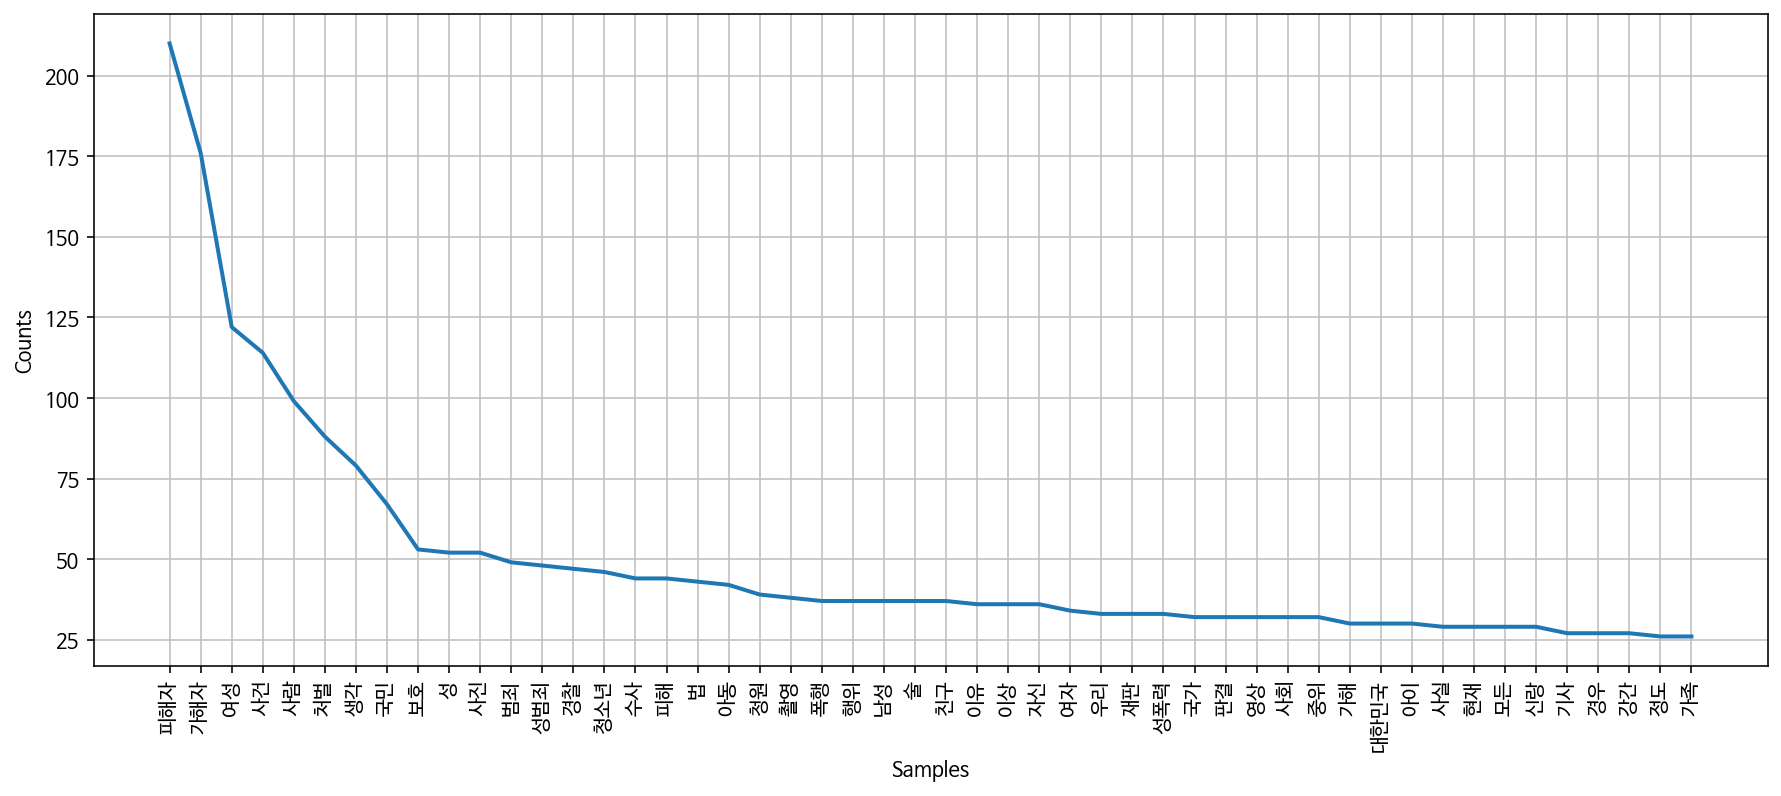

In [19]:
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

피해자, 가해자, 여성, 사건, 사람 순으로 Top 5 words가 나오게 되었네요. 재미있는 작업인 것 같습니다ㅎㅎ

In [20]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [21]:
data = dict(ko.vocab().most_common(150))

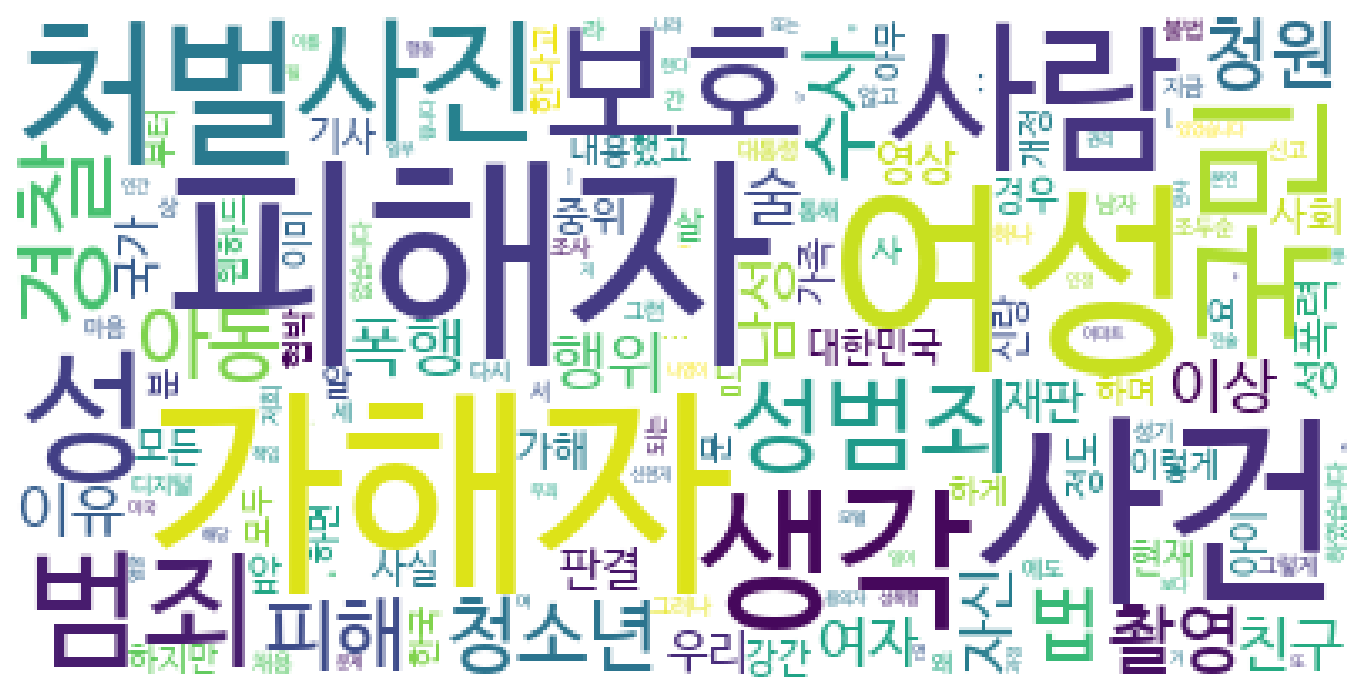

In [22]:
# for win : font_path='c:/Windows/Fonts/malgun.ttf'
# 나눔바른고딕 글씨체 있으면 가능, 없을 경우 font_path를 바꾸세요!
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                      relative_scaling = 0.2,
                      background_color='white',).generate_from_frequencies(data)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

이렇게, 이미, 하였습니다 등의 불용어들이 많네요. 불용어 처리를 더 잘 처리해야겠죠?! 그래도 어느 정도 인권/성평등의 청원 내용을 잘 보여줄 수 있는 토픽이 나온 것 같습니다. 성평등 영역인만큼 피해자/가해자, 여성 등의 단어가 잘 보여지네요.

### Word2Vec을 이용해 단어간 유사성 찾기 

그렇게 이해를 막 할 필요 없이 이런 것도 있구나 하면서 러프하게 이해해주시면 좋을 것 같아요. 이렇게 word2vec이라는게 있는데 이것을 통해서 (맥락 포함한) 단어간 유사성을 볼 수 있겠구나 하구요. gensim이라는 모듈에서 word2vec을 제공하고 있습니다.


In [36]:
import gensim 
from gensim.models import word2vec

In [31]:
okt = Okt()
results = []

for line in humanRights['청원내용']: 
  # 형태소 분석 
  malist = okt.pos(line, norm=True, stem=True)
  # print(malist)
  r = []

  # word2vec 실행
  for word in malist: 
    if not word[1] in ['Josa', 'Eomi','punctuation']:
      r.append(word[0])

  r1 = (" ".join(r)).strip()
  results.append(r1)
  # print(r1)

In [37]:
data_file = 'human_rights.data'
with open(data_file, 'w', encoding='utf-8') as fp: 
  fp.write("\n".join(results))

만든 데이터 날라가지 않도록 우선 저장부터 해두고요! 

In [38]:
data = word2vec.LineSentence(data_file)
model = word2vec.Word2Vec(data, size=200, window=10, hs=1, min_count=2, sg=1)

model.save('human_rights.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [39]:
model = word2vec.Word2Vec.load("human_rights.model")
# 1st 단어: 피해자
model.most_similar(positive=['피해자'])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('계속', 0.9225026369094849),
 ('중심', 0.9096826910972595),
 ('자신', 0.8968992233276367),
 ('사이', 0.8965251445770264),
 ('고소하다', 0.893305778503418),
 ('보이다', 0.8893189430236816),
 ('반', 0.889228105545044),
 ('측', 0.8884307146072388),
 ('참작', 0.8867026567459106),
 ('학교폭력', 0.8865994215011597)]

피해자와 긍정적으로 연관된 단어는 계속 중심, 자신, 사이 등이라고 할 수 있네요. 이것이 어떤 의미가 있는지는 정확히 알 수 없는 것 같고, 더불어 반이나 측과 같이 불용어 처리도 더 되어야 할 것 같네요;;

In [40]:
# 2nd 단어: 가해자
model.most_similar(positive=['가해자'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('가깝다', 0.9094172716140747),
 ('먹이다', 0.8937535285949707),
 ('직접', 0.8929290771484375),
 ('강간미수', 0.8911316394805908),
 ('항소심', 0.8876415491104126),
 ('은', 0.887349545955658),
 ('마시다', 0.8842542171478271),
 ('범행', 0.8795919418334961),
 ('술', 0.8746169805526733),
 ('사이', 0.8714389801025391)]

흠,,, 가해자와 가깝다, 먹이다, 직접 등의 단어는 섬찟합니다,,, 불용어 '은'도 잘 처리되어야 할 듯하구요. 그치만 가해자와 관련된 단어는 잘 도출이 된 것 같습니다.

In [45]:
model.most_similar(positive=['여성', '성범죄'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('팀', 0.9145745635032654),
 ('전반', 0.9113872051239014),
 ('남성', 0.9063940048217773),
 ('플랫폼', 0.8925610780715942),
 ('감독', 0.8894514441490173),
 ('출하', 0.8821606040000916),
 ('아청법', 0.8800077438354492),
 ('성', 0.8784236311912537),
 ('조사', 0.8774358630180359),
 ('그램', 0.8746805191040039)]

여성과 성범죄 두 단어와 함께 관련된 단어들의 리스트입니다. 여러가지가 나오네요. 

## 과제

여기서 끝내긴 너무 아쉬울 것 같네요. 종강 기념 과제가 나갑니다ㅎㅎ EDA 중심으로 한번 배워본 것들을 복습해봅시다. 

- 과제1:
참여인원순 Top10 카테고리를 정렬하여 데이터프레임으로 나타내고, 이를 잘 나타낼 수 있는 표를 사용해 시각화 해주세요. 

- 과제2: 
petition의 청원시작일 칼럼은 청원이 게시된 날짜, 청원답변일은 청원이 답변된 날짜를 의미합니다. 이를 활용해 1) 청원 게시일부터 청원이 답변된 날짜까지의 평균을 구하고, 2) 카테고리별 평균 청원답변일수를 구하여 데이터프레임으로 나타내세요. 

- 과제3: 
카테고리 정치개혁의 청원내용을 wordcloud로 시각화하세요.

## 공부를 끝내며 

드디어 대망의 한글 자연어 처리 기초가 마무리되었습니다. 더불어 코사다마의 첫번째 트랙 데이터 사이언스 입문 스터디도 마무리되었네요. 열심히 공부한 당신, 수고하셨습니다👏👏👏 완벽하게 익히지 못했을 수도 있습니다. 당연히 앞부분은 가물가물..ㅎㅎ 하겠죠! 그러나 제가 생각하기에 중요한 것은 어쨌든 여러분들은 한번씩 들어는 봤다, 코드라도 보긴 봤다 이거에요!..ㅎㅎ 이러한 기술들을 알기만 하는 것으로도 상상력이 생깁니다. 이전에는 이런 방식으로 분석하는 것이 여러분들의 선택지에 없었다면, 이제는 잘 못하더라도 이렇게 해석하고 분석할 수 있다는 선택지의 방향이 생긴 것입니다. 제가 여러분들에게 기초부터 심화까지 가르켜줄 깜냥도 못될 뿐더러 저도 잘 못합니다. 하지만 같이 방향을 세워가며 하나씩 하나씩 배워나갈 수는 있어요. 그래서 이번 학기 너무 힘드셨더라도, 뭔가 배운게 없는 것 같더라도 좌절하지 마시고 잘 리뷰해보시면 좋을 것 같습니다✨🔮 

그동안 무척 고생하셨어요. 우리 다음 학기 스터디에서 다시 만나요🥰👍🙃